# Fitting the Barnes Gyro relation using latent parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import warnings
warnings.filterwarnings('ignore')

For now we'll assume that BPRP and Age have no uncertainty. We'll add the uncertainty on those later with a latent implementation.

$P = \tau^d \times a(B - V - c)^b$

where $P$ is rotation in days
$\tau$ is age (in Myr),
B-V are colour in magnitude,
the rest are free parameters


In [2]:
angus = [0.40, 0.31, 0.45, 0.55] 

def gyro(tau, bv, a, b, c, d):
    return tau*1000**d * a*(bv - c)**b

In [34]:
np.random.seed(12)
npts = 25

bprp_true = np.sort(np.random.normal(1., 0.5, npts))
age_true = np.random.normal(5., 3, npts)
period_true = gyro(age_true, bprp_true, *angus)

sigma_p = 3.*np.ones(npts)
# period_obs = period_true + np.random.randn(npts) * sigma_p
period_obs = period_true

bprp_obs = bprp_true
sigma_bprp = np.zeros(bprp_true.shape)
# sigma_bprp = .05 * np.ones(npts)
# bprp_obs = bprp_true + np.random.randn(npts) * sigma_bprp

sigma_age = np.random.uniform(.05, .1) * age_true
# age_obs = age_true + np.random.randn(npts) * sigma_age
age_obs = age_true

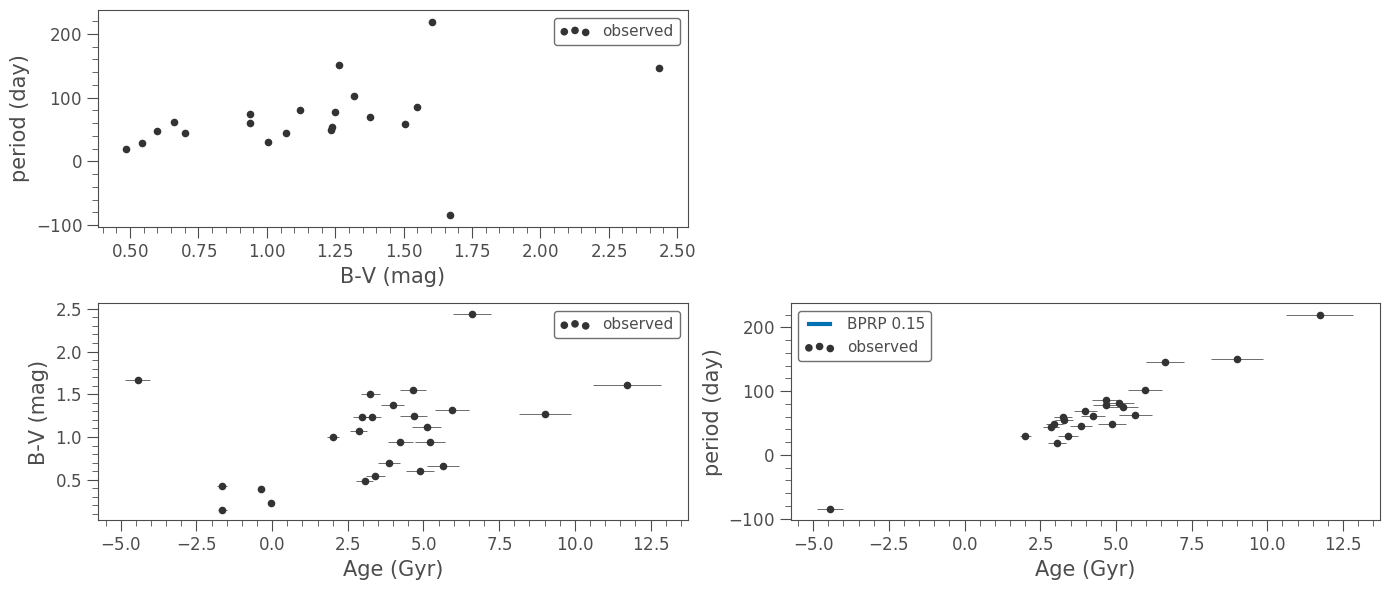

In [45]:
import matplotlib.gridspec as gridspec
import mystyle as ms

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
#     ax0.plot(bprp_true, period_true, label='Truth')
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('B-V (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
#     ax1.plot(age_true, period_true, label='Truth')
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
#     ax2.plot(age_true, bprp_true, label='Truth')
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('B-V (mag)')
    ax2.legend()    
    
    agex = np.linspace(age_true.min(), age_true.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_true.min(), *angus), label='BPRP {:.2f}'.format(bprp_true.min()), lw=3)
#     ax1.plot(agex, gyro(agex, np.mean(bprp_true), *angus), label='BPRP {:.2f}'.format(np.median(bprp_true)), lw=3)
#     ax1.plot(agex, gyro(agex, bprp_true.max(), *angus), label='BPRP {:.2f}'.format(bprp_true.max()), lw=3)    
    ax1.legend()
    
    fig.tight_layout()
    plt.show()

In [46]:
gyro(agex, bprp_true.min(), *angus)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [57]:
pow((bprp_true.min() - 0.1),0.31)

0.39417279508308567

In [54]:
-0.3 ** 0.31

-0.6885057775529797

In [ ]:
angus = [0.40, 0.31, 0.45, 0.55] 

def gyro(tau, bv, a, b, c, d):
    return tau*1000**d * a*(bv - c)**b

Now lets fit for Period using a latent parameter model

In [6]:
latentfit = '''
data {
    int<lower=1> N;
    real<lower=0> P[N];
    real<lower=0> sigma_p[N];
    
    real bprp[N];
    
    real<lower=0> age[N];
    real<lower=0> sigma_age[N];
}
parameters {
    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real<lower=0> d;
    
    real<lower=0> age_true[N];
}
transformed parameters{
    real<lower=0> P_true[N];
    
    for (n in 1:N){
        P_true[n] = (age_true[n]*1000)^d * a * (bprp[n] - c)^b;
    }
}
model {
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    c ~ normal(0., 1.);
    d ~ normal(0., 1.);
    
    age ~ normal(age_true, sigma_age);
    P ~ normal(P_true, sigma_p);
}

'''
sm = pystan.StanModel(model_code = latentfit, model_name='latentfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL latentfit_3256462ca13c1092f0683ed3dd6ac9f1 NOW.


In [7]:
data = {'N' : len(period_obs),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'bprp' : bprp_obs,
       'age' : age_obs,
       'sigma_age' : sigma_age}


init = {'a' : angus[0],
        'b' : angus[1],
        'c' : angus[2],
        'd' : angus[3],
        'age_true' : age_true}

In [8]:
fit = sm.sampling(data=data, iter=5000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [9]:
print(fit)

Inference for Stan model: latentfit_3256462ca13c1092f0683ed3dd6ac9f1.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              2.13    0.01   0.72   0.85   1.62    2.1   2.59   3.63   4679    1.0
b              0.87  3.0e-3   0.14   0.65   0.77   0.85   0.95    1.2   2228    1.0
c               0.3  1.9e-3   0.09   0.07   0.25   0.31   0.37   0.43   2304    1.0
d              0.46  7.5e-4   0.04   0.39   0.43   0.45   0.48   0.56   3245    1.0
age_true[1]    1.69  1.4e-3   0.14   1.42    1.6   1.69   1.79   1.97  10572    1.0
age_true[2]     2.2  1.5e-3   0.16    1.9    2.1    2.2    2.3    2.5  10112    1.0
age_true[3]    2.58  1.7e-3   0.17   2.25   2.47   2.58    2.7   2.92   9916    1.0
age_true[4]    2.44  1.8e-3   0.18   2.09   2.32   2.44   2.57   2.81  10796    1.0
age_true[5]    2.61  1.8e-3    0.2   2.23   2.48   2.61

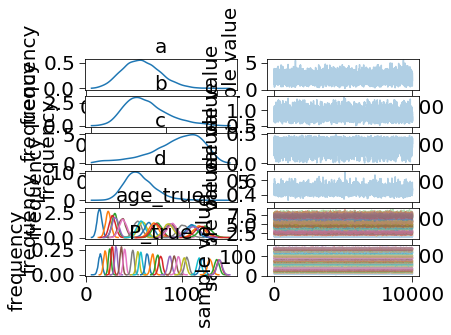

In [10]:
fit.plot()
plt.show()

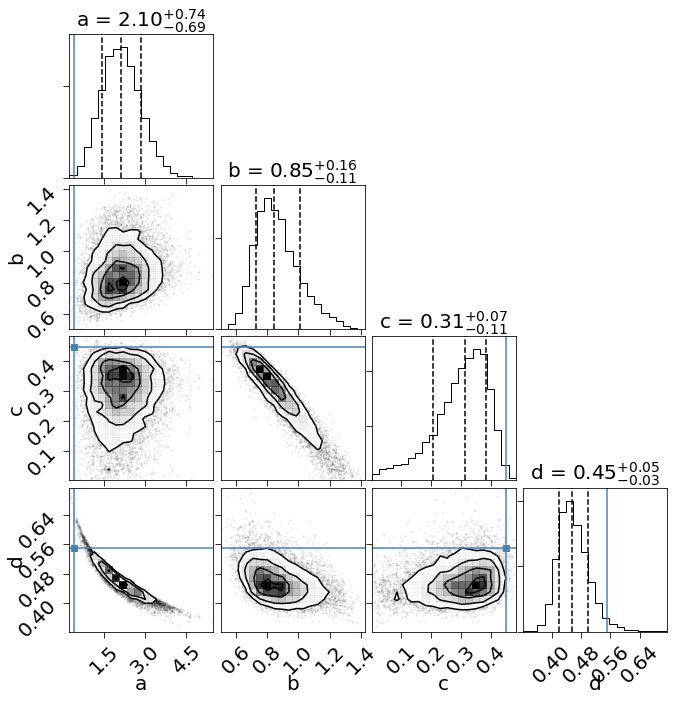

In [11]:
import corner
labels=['a','b','c','d']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, truths=angus,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

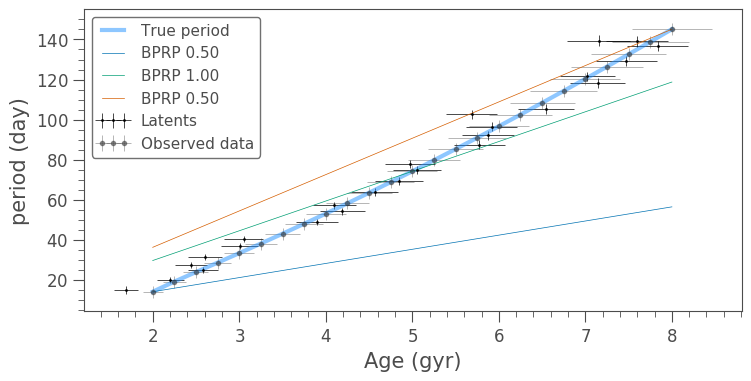

In [25]:
gyrores = [np.median(fit[label]) for label in ['a','b','c','d']]
agex = np.linspace(age_true.min(), age_true.max(), 100)

with plt.style.context(ms.ms):
    fig = plt.figure()
    ax = fig.gca()
        
    ax.plot(age_true, period_true, "dodgerblue", lw=3, label="True period", alpha=.5);
    ax.errorbar(age_latent, np.median(fit['P_true'],axis=0),
                xerr=np.std(fit['age_true'],axis=0), yerr=np.std(fit['P_true'],axis=0),
               fmt='o', c='k', label="Latents");
    ax.errorbar(age_true, period_obs, yerr=sigma_p, xerr=sigma_age, 
                fmt='o', ms=3, alpha=0.5, label="Observed data");
    
    ax.plot(agex, gyro(agex, bprp_true.min(), *angus), label='BPRP {:.2f}'.format(bprp_true.min()))
    ax.plot(agex, gyro(agex, np.median(bprp_true), *angus), label='BPRP {:.2f}'.format(np.median(bprp_true)))
    ax.plot(agex, gyro(agex, bprp_true.max(), *angus), label='BPRP {:.2f}'.format(bprp_true.min()))

        
    ax.set_xlabel('Age (gyr)')
    ax.set_ylabel('period (day)')
    ax.legend()
    plt.show(); 

#### Plot for low, mid and highest BPRP

In [ ]:
with plt.style.context(ms.ms):
    fig = plt.figure()
    ax = fig.gca()
    
    ax.plot(age_true, period_true, label='Truth')
    ax.scatter(age_obs, period_obs,zorder=1, label='observed')
    ax.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax.set_xlabel('Age (Gyr)')
    ax.set_ylabel('period (day)')
    ax.legend()    
    
    fig.tight_layout()
    plt.show()